In [28]:
# ---------- Imports ----------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [29]:
# Optional XGBoost
try:
    from xgboost import XGBRegressor
    xgboost_available = True
except:
    xgboost_available = False

from sklearn import __version__ as sklearn_version
from packaging import version

In [30]:
# ---------- Load dataset ----------
data = pd.read_csv('Housing.csv')
print('Dataset loaded. Shape:', data.shape)

Dataset loaded. Shape: (545, 13)


In [31]:
# ---------- Handle target column ----------
# Ensure 'price' is numeric
if 'price' in data.columns:
    target_col = 'price'
elif 'Price' in data.columns:
    target_col = 'Price'
else:
    target_col = data.columns[-1]

In [32]:
# Convert to numeric if needed
data[target_col] = pd.to_numeric(data[target_col], errors='coerce')
data = data.dropna(subset=[target_col])  # drop rows with non-numeric target
print(f"Target column '{target_col}' converted to numeric.")

Target column 'price' converted to numeric.


In [33]:
# ---------- Feature selection ----------
X = data.drop(columns=[target_col])
y = data[target_col]

In [34]:
# Identify numeric and categorical columns
numeric_feats = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_feats = X.select_dtypes(include=['object', 'category']).columns.tolist()

print('Numeric features:', numeric_feats)
print('Categorical features:', cat_feats)


Numeric features: ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
Categorical features: ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']


In [35]:
# ---------- Train-test split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [36]:
# ---------- Pipelines ----------
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


In [37]:
# Handle sklearn version differences for OneHotEncoder
if version.parse(sklearn_version) >= version.parse("1.2"):
    onehot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
else:
    onehot = OneHotEncoder(handle_unknown='ignore', sparse=False)

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', onehot)
])

In [38]:
# ---------- Combine preprocessing ----------
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_feats),
    ('cat', categorical_pipeline, cat_feats)
])

# ---------- Baseline model: Linear Regression ----------
lr_pipeline = Pipeline([
    ('pre', preprocessor),
    ('lr', LinearRegression())
])

print('\nTraining Linear Regression baseline...')
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)


Training Linear Regression baseline...


In [39]:
# ---------- Evaluation function ----------
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

results = {}
results['LinearRegression'] = evaluate(y_test, y_pred_lr)
print('\nLinear Regression results:', results['LinearRegression'])

# ---------- Random Forest ----------
rf_pipeline = Pipeline([
    ('pre', preprocessor),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

print('\nTraining default RandomForest...')
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
results['RandomForest_default'] = evaluate(y_test, y_pred_rf)
print('RandomForest default results:', results['RandomForest_default'])



Linear Regression results: {'RMSE': np.float64(1324506.9600914402), 'MAE': 970043.4039201644, 'R2': 0.6529242642153175}

Training default RandomForest...
RandomForest default results: {'RMSE': np.float64(1403925.371676078), 'MAE': 1025961.1683486238, 'R2': 0.610054593532394}


In [40]:
# ---------- Randomized Search for RandomForest ----------
rf_param_dist = {
    'rf__n_estimators': [100, 200, 300, 500],
    'rf__max_depth': [None, 10, 20, 30, 50],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2']
}

rs_rf = RandomizedSearchCV(
    rf_pipeline,
    rf_param_dist,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=3,
    random_state=42,
    n_jobs=-1
)

print('\nStarting RandomizedSearchCV for RandomForest...')
rs_rf.fit(X_train, y_train)
print('Best RF params:', rs_rf.best_params_)

best_rf = rs_rf.best_estimator_
y_pred_rf_best = best_rf.predict(X_test)
results['RandomForest_tuned'] = evaluate(y_test, y_pred_rf_best)
print('RandomForest tuned results:', results['RandomForest_tuned'])



Starting RandomizedSearchCV for RandomForest...
Best RF params: {'rf__n_estimators': 500, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 2, 'rf__max_features': 'sqrt', 'rf__max_depth': None}
RandomForest tuned results: {'RMSE': np.float64(1407486.8404945985), 'MAE': 1016700.2448787538, 'R2': 0.6080736621294}


In [41]:
# ---------- XGBoost (optional) ----------
if xgboost_available:
    xgb_pipeline = Pipeline([
        ('pre', preprocessor),
        ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))
    ])

    print('\nTraining default XGBoost...')
    xgb_pipeline.fit(X_train, y_train)
    y_pred_xgb = xgb_pipeline.predict(X_test)
    results['XGBoost_default'] = evaluate(y_test, y_pred_xgb)
    print('XGBoost default results:', results['XGBoost_default'])

    xgb_param_dist = {
        'xgb__n_estimators': [100, 200, 400],
        'xgb__max_depth': [3, 5, 7, 10],
        'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'xgb__subsample': [0.6, 0.8, 1.0],
        'xgb__colsample_bytree': [0.6, 0.8, 1.0]
    }

    rs_xgb = RandomizedSearchCV(
        xgb_pipeline,
        xgb_param_dist,
        n_iter=20,
        scoring='neg_root_mean_squared_error',
        cv=3,
        random_state=42,
        n_jobs=-1
    )

    print('\nStarting RandomizedSearchCV for XGBoost...')
    rs_xgb.fit(X_train, y_train)
    print('Best XGB params:', rs_xgb.best_params_)

    best_xgb = rs_xgb.best_estimator_
    y_pred_xgb_best = best_xgb.predict(X_test)
    results['XGBoost_tuned'] = evaluate(y_test, y_pred_xgb_best)
    print('XGBoost tuned results:', results['XGBoost_tuned'])


Training default XGBoost...
XGBoost default results: {'RMSE': np.float64(1438064.4086382224), 'MAE': 1057455.0, 'R2': 0.5908595323562622}

Starting RandomizedSearchCV for XGBoost...
Best XGB params: {'xgb__subsample': 0.6, 'xgb__n_estimators': 100, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.05, 'xgb__colsample_bytree': 0.8}
XGBoost tuned results: {'RMSE': np.float64(1296989.8363210098), 'MAE': 971900.1875, 'R2': 0.6671956777572632}


In [42]:
# ---------- Summarize results ----------
print('\n=== Summary of results ===')
for name, metrics in results.items():
    print(f"{name}: RMSE={metrics['RMSE']:.4f}, MAE={metrics['MAE']:.4f}, R2={metrics['R2']:.4f}")

# ---------- Select the best model ----------
best_model_name = min(results.items(), key=lambda x: x[1]['RMSE'])[0]
print('\nBest model by RMSE:', best_model_name)

if best_model_name.startswith('RandomForest') and 'best_rf' in locals():
    final_model = best_rf
elif best_model_name.startswith('XGBoost') and 'best_xgb' in locals():
    final_model = best_xgb
else:
    final_model = lr_pipeline if best_model_name == 'LinearRegression' else rf_pipeline



=== Summary of results ===
LinearRegression: RMSE=1324506.9601, MAE=970043.4039, R2=0.6529
RandomForest_default: RMSE=1403925.3717, MAE=1025961.1683, R2=0.6101
RandomForest_tuned: RMSE=1407486.8405, MAE=1016700.2449, R2=0.6081
XGBoost_default: RMSE=1438064.4086, MAE=1057455.0000, R2=0.5909
XGBoost_tuned: RMSE=1296989.8363, MAE=971900.1875, R2=0.6672

Best model by RMSE: XGBoost_tuned


In [43]:
# ---------- Save the best model ----------
joblib.dump(final_model, 'best_model.pkl')
print("✅ Saved best model to 'best_model.pkl'")


✅ Saved best model to 'best_model.pkl'


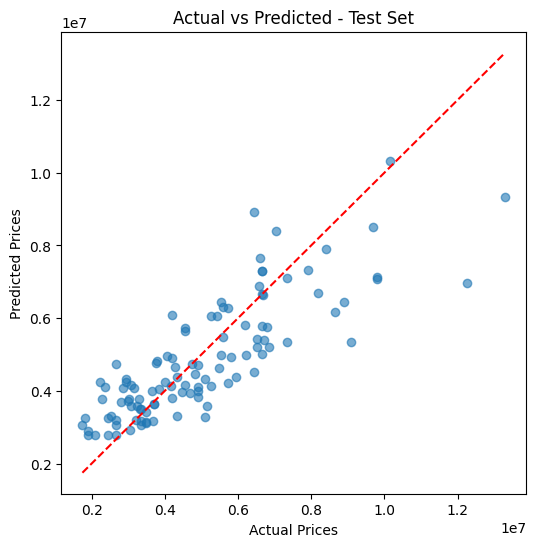

In [44]:
# ---------- Plot predicted vs actual ----------
plt.figure(figsize=(6,6))
plt.scatter(y_test, final_model.predict(X_test), alpha=0.6)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted - Test Set')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.show()